## Biweekly Report 4

### Claire Lu

Batch Normalization stabilizes the internal feature distributions, reducing shifts in mean and variance across training epochs. This stabilization leads to smoother optimization and faster convergence. To demonstrate, I'll compare training dynamics, gradiants, and internal covariate shift between models with and without batch normalization. I'll train deep neural networks and implement it manually and compare the performance against a baseline model without batch normalization. The dataset for testing and validation will be MNIST.

Benefits of batch normalization:
1. higher learning rate
2. less sensitive to initialization
3. less sensitive to activation functions
4. regularization effects
5. preserve gradient magnitudes

It should address the problem of deep neural networks being difficult to train due to input distribution in each layer changing during training. As earlier layers update their weights, the activations passed to later layers shift in mean and variance, resulting in interval covariate shift. Thus, the network continously redapts which makes training more slow.
Batch normalization reduces this effect by normalizing activations, each batch is normalized using its mean and variance, then scaled and shifted using learnable parameters.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

Running on: cuda


I'll use MNIST (with normalization) as the dataset for testing. This is the standard tensor conversion with normalized pixel values with $\mu$ = 0.

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_data = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
trainloader = DataLoader(train_data, batch_size=128, shuffle=True)
testloader = DataLoader(test_data, batch_size=128, shuffle=False)

### Batch Normalization Implementation

A neural network is defined by minibatch of inputs:

$$
\{x_1, x_2, \ldots, x_m\}
$$ where \(m\) is the minibatch size.

Batch normalization begins by computing the batch mean and variance where the running averages of means and variance are maintained for use during inference

$$
\mu = \frac{1}{m} \sum_{i=1}^{m} x_i
$$

$$
\sigma^2 = \frac{1}{m} \sum_{i=1}^{m} (x_i - \mu)^2
$$


The activations are normalized to zero mean and unit variance:

$$
\hat{x}_i = \frac{x_i - \mu}{\sigma^2 + \epsilon}
$$

$\gamma$ is a learnable scale parameter  
$\beta$ is a learnable shift parameter  
$\epsilon$ is a small constant so division by zero cannot be carried out

$\sigma^2$ and $\mu$ depend on specific minibatch, but at test time the network processes one example at the time. This means the statistics are determined by runnign averages which are updated with exponential moving averages. Those are the ones used for inference.

and the trainable parameters $\gamma$, $\beta$ are laerned, with running averages tracked for evaluation.These parameters are trained jointly with the rest of the network via backpropagation. Normalization is peformed by 
$$
\hat{x}_i = \gamma \frac{x_i - \mu}{\sigma^2 + \epsilon}+ \beta
$$

The implementation follows the derivation, where the mean and variance over the current minibatch are computed, with the stored running estimates used during inference. The normalized activation is scaled and shifted.

In [3]:
class CustomBatchNorm1d(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super().__init__()
        self.eps = eps
        self.momentum = momentum
        
        #leanarable params
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))
        
        #running mu and signas
        self.register_buffer("running_mean", torch.zeros(num_features))
        self.register_buffer("running_var", torch.ones(num_features))

    def forward(self, x):
        if self.training:
            batch_mean = x.mean(dim=0)
            batch_var = x.var(dim=0, unbiased=False)

            self.running_mean = (
                (1 - self.momentum) * self.running_mean
                + self.momentum * batch_mean.detach()
            )
            self.running_var = (
                (1 - self.momentum) * self.running_var
                + self.momentum * batch_var.detach()
            )
        else:
            batch_mean = self.running_mean
            batch_var = self.running_var

        x_hat = (x - batch_mean) / torch.sqrt(batch_var + self.eps)#normalization
        return self.gamma * x_hat + self.beta


We train two fully connected MLP's on MNIST. The multilayer perceptron without batch normalization relies only on ReLU activations and normal linear layers. No normalization is applied.
the MLP with implemented batch normalization (self.bn1, self.bn2) applies it after each linear layer and prior to activation. Adding it should stablize activations across training, such that each layer has more scaled distributions.

In [4]:
class MLP_NoBN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)        # flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class MLP_WithBN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.bn1 = CustomBatchNorm1d(256)

        self.fc2 = nn.Linear(256, 128)
        self.bn2 = CustomBatchNorm1d(128)

        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        return self.fc3(x)


The training loop is intended to track variance since, with batch normalization, activation variance should be more consistent during the training. It uses Adam optimizer (learning rate of 0.001 created) and cross entrophy loss as the training loss function. The statistics of loss, accuracy, gradient norm, and activation variance will be accumulated. In mini-batch processing, the function iterates over training data and each batch undergoes a forward pass whoere model predicts outputs & loss is computed, and a backwards pass where gradiants are calculated and parameters updated. The L2 norm of gradients are computed to monitor optimization's stability. If the model has a  fully connected layer then the variance of its activations will be noted. At the end of evaluation, the list of statistics are averaged over the trainloader and outputted.

In [5]:
def train_model(model, name, epochs=30):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    history = {
        "loss": [],
        "accuracy": [],
        "grad_norm": [],
        "act_var": []
    }

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        grad_total = 0.0
        act_vars = 0.0

        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            total_norm = 0
            for p in model.parameters():
                if p.grad is not None:
                    total_norm += p.grad.data.norm(2).item() ** 2
            grad_total += (total_norm ** 0.5)

            optimizer.step()
            running_loss += loss.item()


            with torch.no_grad():
                if hasattr(model, 'fc1'):
                    a = model.fc1(images.view(-1, 28*28))
                    act_vars += a.var().item()

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        acc = 100 * correct / total

        history["loss"].append(running_loss / len(trainloader))
        history["accuracy"].append(acc)
        history["grad_norm"].append(grad_total / len(trainloader))
        history["act_var"].append(act_vars / len(trainloader))
        if epoch >= epochs - 5:
            print(f"{name} | Epoch {epoch+1}/{epochs}  Loss: {running_loss/len(trainloader):.4f}  Acc: {acc:.2f}%")

    return history


To test, train a model without Batch normalization and one with (expected that batch norm has lower loss):

In [6]:
model_no_bn = MLP_NoBN()
history_no_bn = train_model(model_no_bn, "No BN")

model_with_bn = MLP_WithBN()
history_with_bn = train_model(model_with_bn, "With BN")


No BN | Epoch 26/30  Loss: 0.0130  Acc: 97.69%
No BN | Epoch 27/30  Loss: 0.0135  Acc: 97.80%
No BN | Epoch 28/30  Loss: 0.0152  Acc: 98.05%
No BN | Epoch 29/30  Loss: 0.0169  Acc: 97.59%
No BN | Epoch 30/30  Loss: 0.0108  Acc: 97.94%
With BN | Epoch 26/30  Loss: 0.0061  Acc: 98.15%
With BN | Epoch 27/30  Loss: 0.0034  Acc: 98.53%
With BN | Epoch 28/30  Loss: 0.0039  Acc: 98.17%
With BN | Epoch 29/30  Loss: 0.0064  Acc: 98.19%
With BN | Epoch 30/30  Loss: 0.0043  Acc: 98.19%


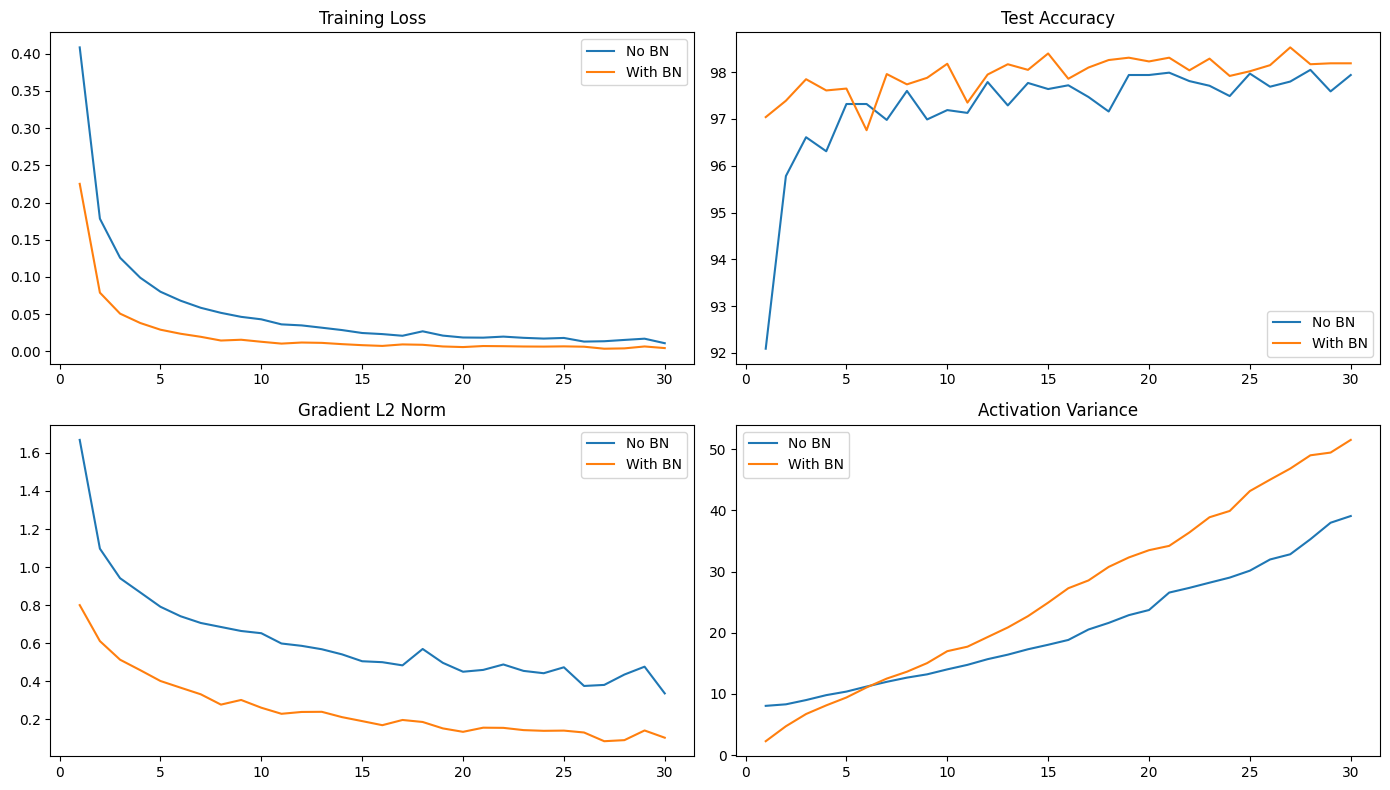

In [7]:
epochs = range(1, len(history_no_bn["loss"]) + 1)

plt.figure(figsize=(14,8))

plt.subplot(2,2,1)
plt.plot(epochs, history_no_bn["loss"], label="No BN")
plt.plot(epochs, history_with_bn["loss"], label="With BN")
plt.title("Training Loss")
plt.legend()

plt.subplot(2,2,2)
plt.plot(epochs, history_no_bn["accuracy"], label="No BN")
plt.plot(epochs, history_with_bn["accuracy"], label="With BN")
plt.title("Test Accuracy")
plt.legend()

plt.subplot(2,2,3)
plt.plot(epochs, history_no_bn["grad_norm"], label="No BN")
plt.plot(epochs, history_with_bn["grad_norm"], label="With BN")
plt.title("Gradient L2 Norm")
plt.legend()

plt.subplot(2,2,4)
plt.plot(epochs, history_no_bn["act_var"], label="No BN")
plt.plot(epochs, history_with_bn["act_var"], label="With BN")
plt.title("Activation Variance")
plt.legend()

plt.tight_layout()
plt.show()


#### Results and Conclusions

The expected results are loss decreasing faster with batch normalization, increased accuracy, gradient norms are 'smoother', and activation variance is more stable. Thus, the inclusion of batch normalization makes optimization less sentitive to the weight initialization and learning rate. 

Visualizations demonstrate the model with batch normalization shows a faster decrease in training loss, while model without reduces loss more slowly. Since batch normalization helps stablize by reducing internal covariate shift, the model can train mroe smoothly and converge faster. The batch normalized model achieved higher accuracy and reduced overfiting and improved generalization. Thus, the model generalizes better to data. The gradient norms appear smaller and with less variance. This is benefical since it makes the optimization more smoother with stable gradients making faster convergence.

The activation variance in batch normalization increases over epochs, but is initially lower and more linearly controlled. Without batch normalization, it is much higher since the scale of activations grow and each layer produces larger values. Thus, batch normalization is necessary for reducing the possibility of higher activation variance early on. At some point, the variance in batch normalization overtakes the variance of the model without it. 

Future work can include evaluation on more datasets like imagenet, or use CNNs to see if improvements scale to those type of deeper architectures. Variables like batch size can also be experimented on to see how differences affect performance.
